# Problem Statement:
This problem is quite different than default NLP task in which we are asked to predict the sentiment of sentence. In this competition given, the polarity we are asked to determine/select the words that are going to decide the polarity of the sentence.

# Evaluation Metric

Evaluation metric here is **Jacard Score**. Which is also called Intersection over union and used mainly in CNN tasks. 
![](https://www.displayr.com/wp-content/uploads/2018/09/Jaccard-formula.png)
![](https://upload.wikimedia.org/wikipedia/commons/c/c7/Intersection_over_Union_-_visual_equation.png)

# Table of Content
- 1. Dataset and Libraries
   - 1.1 Importing libraries
   - 1.2 Reading Data
- 2. Exploratory Data Analysis
   - 2.1 Finding the missing values
   - 2.2 Distribution of sentiment class
- 3. Analysis of text and selected_data
   - 3.1 Percentage of neutral, negative, positive words in train and test data
   - 3.2 Length of words for in each category
   - 3.3 Comparing test and selected text column
- 4. Text Statistics
   - 4.1 Percentage of text column sentences is equal selected_text column for neutral sentiment
   - 4.2 Punctuation Count
- 5. Word Cloud
- 6. N Grams
- 7. DistilBERT + SQuAD + Question Answering Technique
   - 7.1 Data Preprocessing

**Do upvote this kernal also. It helped me alot in BERT modelling**

https://www.kaggle.com/jonathanbesomi/question-answering-starter-pack

# 1. Dataset and Libraries

**1.1 Importing Libraries**

In [1]:
!mkdir data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud, STOPWORDS
import tensorflow as tf
import missingno as msno
from collections import defaultdict
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


 **1.2 Reading Data**

In [3]:
train = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/train.csv")
test = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/test.csv")
sample_submission = pd.read_csv("/kaggle/input/tweet-sentiment-extraction/sample_submission.csv")

In [4]:
train.shape, test.shape

((27481, 4), (3534, 3))

# 2. Exploratory Data Analysis

**2.1 Finding the missing values**

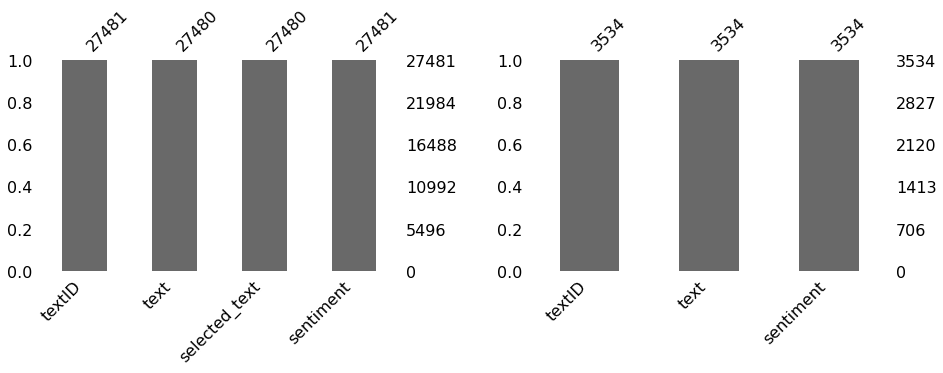

In [5]:
# Finding the missing values
fig, axes = plt.subplots(1, 2, figsize=(15,6))
plt.tight_layout(pad = 10)
msno.bar(train, ax = axes[0])
msno.bar(test, ax = axes[1])

There is one missing value in text and selected_text column in train data

In [6]:
print(train[train["text"].isnull() == True])
# We can drop this row
train.dropna(inplace = True)

         textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral


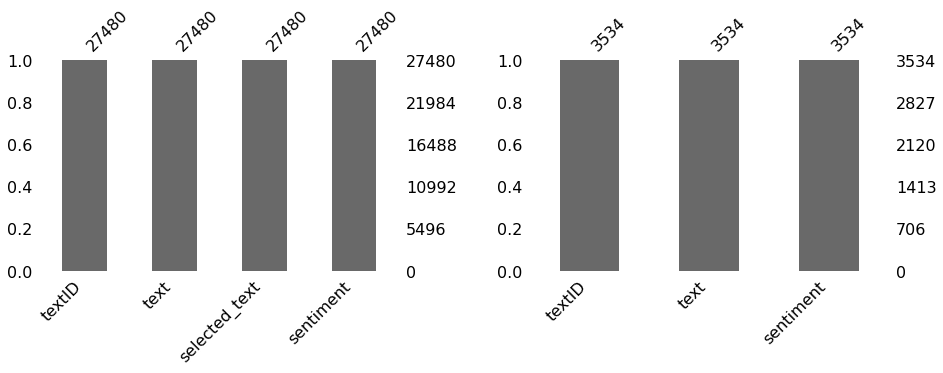

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
plt.tight_layout(pad = 10)
msno.bar(train, ax = axes[0])
msno.bar(test, ax = axes[1])

No null value left in the train and test data

**2.2 Distribution of missing class**

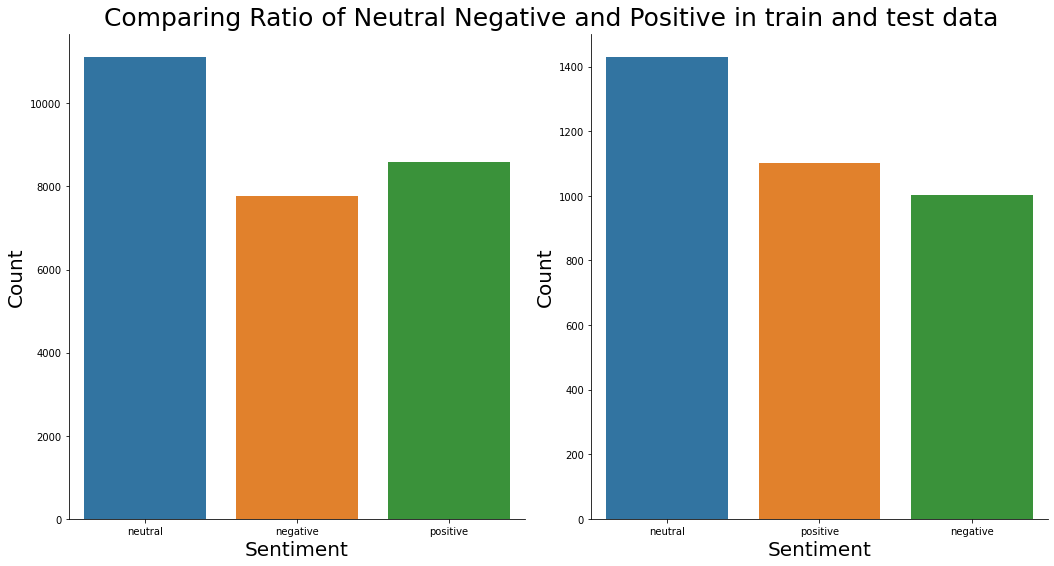

In [8]:
# Distribution of sentiment class
fig, axes = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle("Comparing Ratio of Neutral Negative and Positive in train and test data", fontsize = 25)
plt.tight_layout(pad = 3.5)
sns.countplot(x = "sentiment", data = train, ax = axes[0])
sns.countplot(x = "sentiment", data = test, ax = axes[1])
axes[0].set_xlabel("Sentiment", fontsize = 20)
axes[0].set_ylabel("Count", fontsize = 20)
axes[1].set_xlabel("Sentiment", fontsize = 20)
axes[1].set_ylabel("Count", fontsize = 20)
sns.despine()

# 3. Analysis of text and selected_text

**3.1 Percentage of neutral, negative, positive words in train and test data**

In [9]:
# Percentage of neutral, negative, positive words in train and test data
def pert_count(data, category):
    return (len(data[data["sentiment"] == category])/len(data)) * 100

print(f"Percentage of neutral words in train --> {pert_count(train, 'neutral')}%")
print(f"Percentage of negative words in train --> {pert_count(train, 'negative')}%")
print(f"Percentage of positive words in train --> {pert_count(train, 'positive')}%")
print(f"Percentage of neutral words in test --> {pert_count(test, 'neutral')}%")
print(f"Percentage of negative words in test --> {pert_count(test, 'negative')}%")
print(f"Percentage of positive words in test --> {pert_count(test, 'positive')}%")

Percentage of neutral words in train --> 40.45487627365357%
Percentage of negative words in train --> 28.315138282387192%
Percentage of positive words in train --> 31.22998544395924%
Percentage of neutral words in test --> 40.46406338426712%
Percentage of negative words in test --> 28.324844368986984%
Percentage of positive words in test --> 31.2110922467459%


**We can see from above analysis that the percentage of neutral, positive and negative words are quite similar. It may be due to the fact that train and test data came from same sample**

**3.2 Length of words for in each category**

In [10]:
# Length of words for in each category
def len_sent(data):
    return len(data.split())

train["num_words_text"] = train["text"].apply(lambda x : len_sent(x))
test["num_words_text"] = test["text"].apply(lambda x : len_sent(x))
train["num_words_selected_text"] = train["selected_text"].apply(lambda x : len_sent(x))

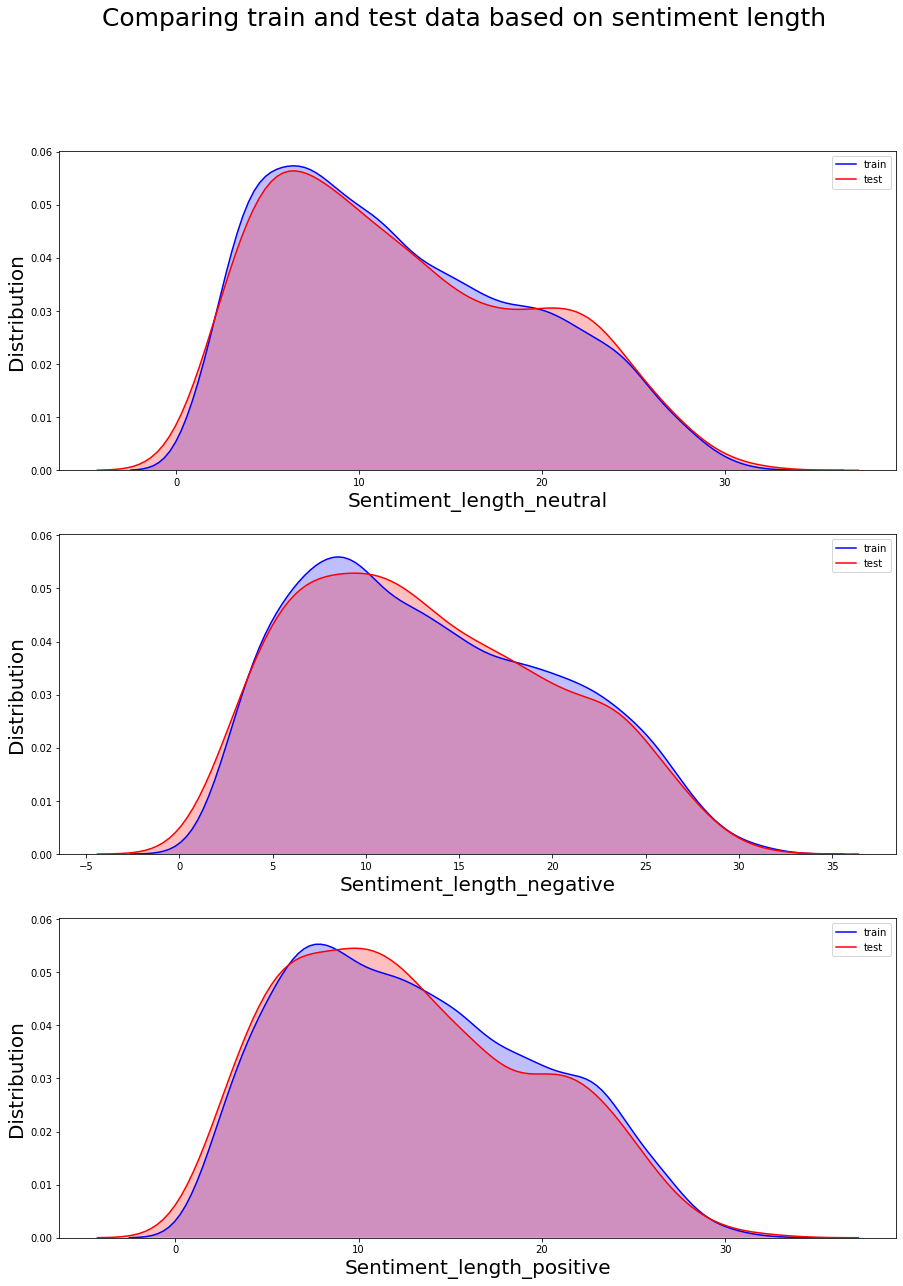

In [11]:
fig, axes = plt.subplots(3, 1, sharey = True, figsize = (15, 20))
fig.suptitle("Comparing train and test data based on sentiment length", fontsize = 25)
sns.kdeplot(train[train["sentiment"] == "neutral"]["num_words_text"].values, ax  = axes[0], shade = True, color = "blue", label = "train")
sns.kdeplot(test[test["sentiment"] == "neutral"]["num_words_text"].values, ax  = axes[0], shade = True, color = "red", label = "test")
sns.kdeplot(train[train["sentiment"] == "negative"]["num_words_text"].values, ax  = axes[1], shade = True, color = "blue", label = "train")
sns.kdeplot(test[test["sentiment"] == "negative"]["num_words_text"].values, ax  = axes[1], shade = True, color = "red", label = "test")
sns.kdeplot(train[train["sentiment"] == "positive"]["num_words_text"].values, ax  = axes[2], shade = True, color = "blue", label = "train")
sns.kdeplot(test[test["sentiment"] == "positive"]["num_words_text"].values, ax  = axes[2], shade = True, color = "red", label = "test")
axes[0].set_xlabel("Sentiment_length_neutral", fontsize = 20)
axes[0].set_ylabel("Distribution", fontsize = 20)
axes[1].set_xlabel("Sentiment_length_negative", fontsize = 20)
axes[1].set_ylabel("Distribution", fontsize = 20)
axes[2].set_xlabel("Sentiment_length_positive", fontsize = 20)
axes[2].set_ylabel("Distribution", fontsize = 20)
plt.legend()

We can see from above distribution plots that distribution of word length is quite similar in train and test data for each sentiment category

**3.3 Comparing test and selected text column**

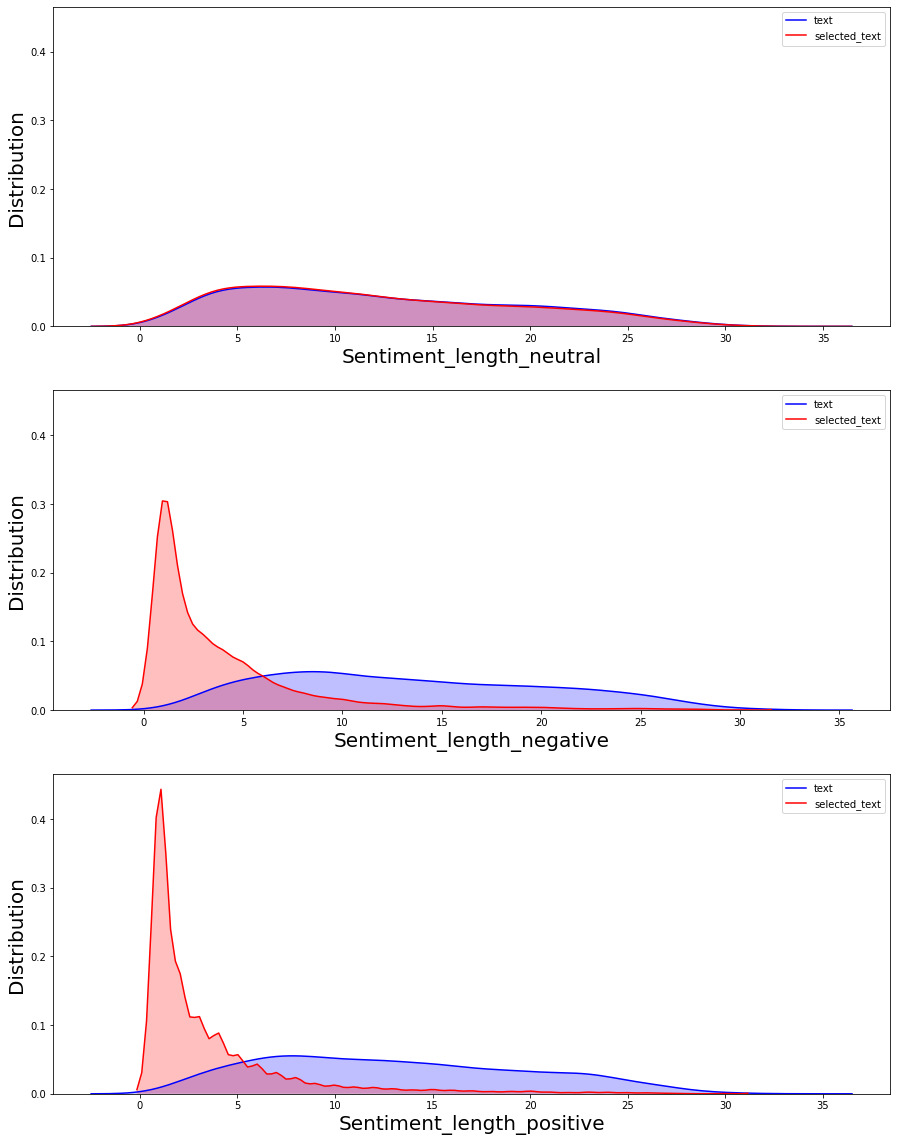

In [12]:
# Comparing test and selected text column
fig, axes = plt.subplots(3, 1, sharey = True, figsize = (15, 20))
fig.suptitle("", fontsize = 25)
sns.kdeplot(train[train["sentiment"] == "neutral"]["num_words_text"].values, ax  = axes[0], shade = True, color = "blue", label = "text")
sns.kdeplot(train[train["sentiment"] == "neutral"]["num_words_selected_text"].values, ax  = axes[0], shade = True, color = "red", label = "selected_text")
sns.kdeplot(train[train["sentiment"] == "negative"]["num_words_text"].values, ax  = axes[1], shade = True, color = "blue", label = "text")
sns.kdeplot(train[train["sentiment"] == "negative"]["num_words_selected_text"].values, ax  = axes[1], shade = True, color = "red", label = "selected_text")
sns.kdeplot(train[train["sentiment"] == "positive"]["num_words_text"].values, ax  = axes[2], shade = True, color = "blue", label = "text")
sns.kdeplot(train[train["sentiment"] == "positive"]["num_words_selected_text"].values, ax  = axes[2], shade = True, color = "red", label = "selected_text")
axes[0].set_xlabel("Sentiment_length_neutral", fontsize = 20)
axes[0].set_ylabel("Distribution", fontsize = 20)
axes[1].set_xlabel("Sentiment_length_negative", fontsize = 20)
axes[1].set_ylabel("Distribution", fontsize = 20)
axes[2].set_xlabel("Sentiment_length_positive", fontsize = 20)
axes[2].set_ylabel("Distribution", fontsize = 20)
plt.legend()

We can see from above graphs that for neutral sentences the distribution of length is approximately the same in text and selected_text column. For negative and positive sentiment the length of selected_text column is shorter than text column

# 4. Text Statistics

 **4.1 Percentage of text column sentences is equal selected_text column for neutral sentiment**

In [13]:
train["text"] = train["text"].apply(lambda x : x.strip())
train["selected_text"] = train["selected_text"].apply(lambda x : x.strip())


train["is_equal"] = (train["text"] == train["selected_text"])
df_neutral = train[train["sentiment"] == "neutral"]
percentage = (len(df_neutral[df_neutral["is_equal"] == True])/len(df_neutral)) * 100
print(f"Percentage of text column sentences is equal selected_text column for neutral sentiment --> {percentage}")

Percentage of text column sentences is equal selected_text column for neutral sentiment --> 89.9883061977152


**As most of the train["text"] data is same as train["selected_text"] for neutral sentiment. So I will simply copy paste test["text"] for neutral sentiment prediction

**4.2 Punctuation count**

In [14]:
# Punctuation count in train["text"], train["selected_text"]
def punc_count(data):
    return len([w for w in data if w in string.punctuation])

train["text_punc_count"] = train["text"].apply(lambda x : punc_count(x))
train["selected_text_punc_count"] = train["selected_text"].apply(lambda x : punc_count(x))

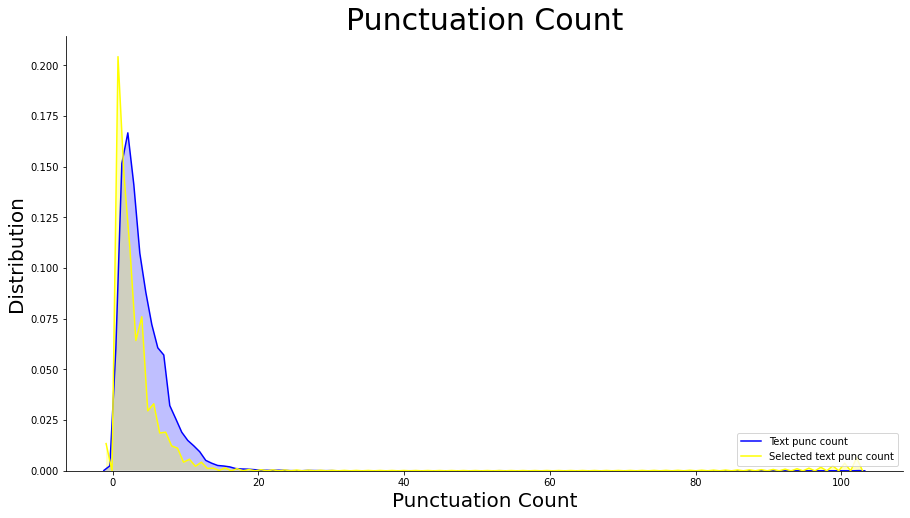

In [15]:
plt.figure(figsize = (15, 8))
sns.kdeplot(train["text_punc_count"].values, shade = True, color = "blue", label = "Text punc count")
sns.kdeplot(train["selected_text_punc_count"].values, shade = True, color = "yellow", label = "Selected text punc count")
plt.title("Punctuation Count", fontsize = 30)
plt.xlabel("Punctuation Count", fontsize = 20)
plt.ylabel("Distribution", fontsize = 20)
sns.despine()
plt.legend(loc = "lower right")

# 5. Word Cloud

In [16]:
# Most repeated words in text column and selected_text
stopwords = set(STOPWORDS)
def word_cloud(data, title):
    wordcloud = WordCloud(
    background_color = "black",
    max_font_size = 40,
    max_words = 200,
    stopwords = stopwords,
    scale = 3).generate(str(data))
    fig = plt.figure(figsize = (15, 15))
    plt.axis("off")
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.25)

    plt.imshow(wordcloud)
    plt.show()

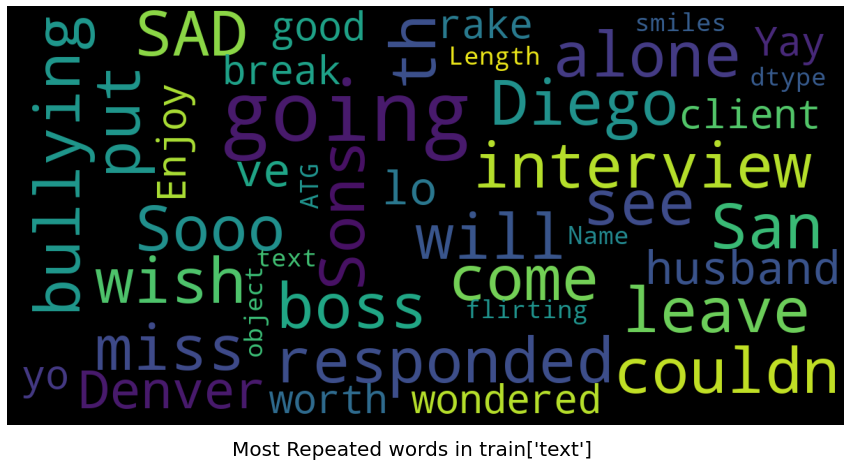

In [17]:
word_cloud(train["text"], "Most Repeated words in train['text']")

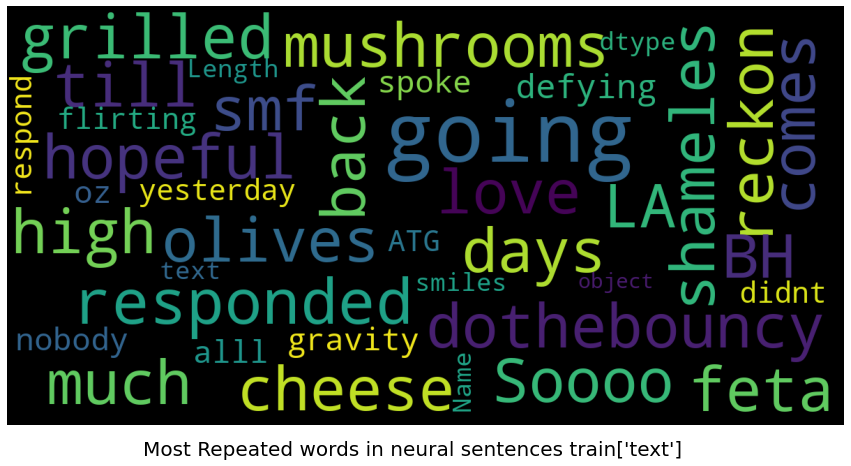

In [18]:
word_cloud(train[train["sentiment"] == "neutral"]["text"], "Most Repeated words in neural sentences train['text']")

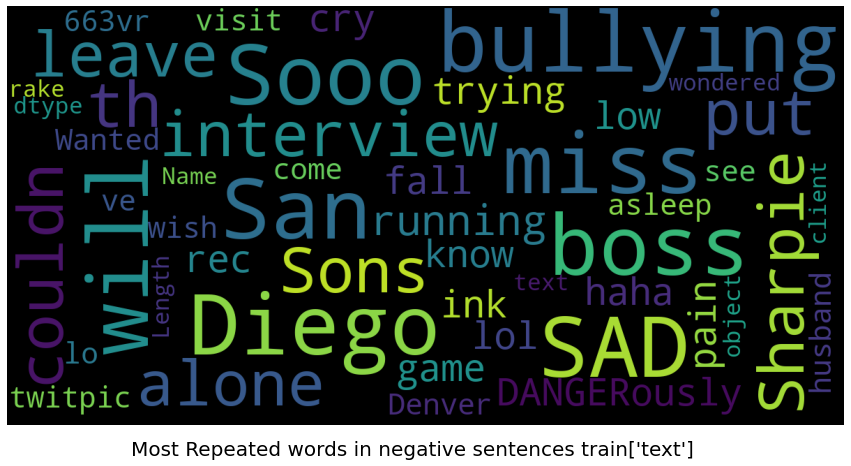

In [19]:
word_cloud(train[train["sentiment"] == "negative"]["text"], "Most Repeated words in negative sentences train['text']")

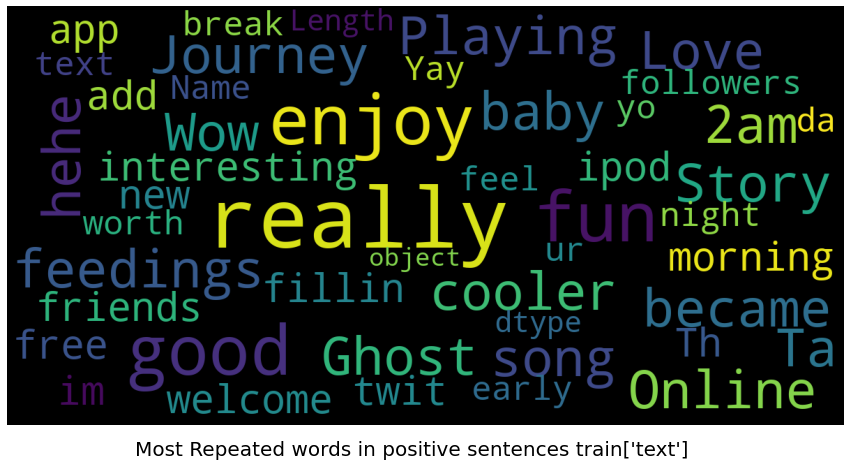

In [20]:
word_cloud(train[train["sentiment"] == "positive"]["text"], "Most Repeated words in positive sentences train['text']")

# 6. N Grams

In [21]:
# N-Grams for neutral, positive negative sentences
def n_grams(ngram, data):
    freq_dict = defaultdict(int)
    for text in data:
        tokens = [w for w in text.lower().split() if w != " " if w not in stopwords]
        ngrams = zip(*[tokens[i:] for i in range(ngram)])
        list_grams = [" ".join(ngram) for ngram in ngrams]
        for word in list_grams:
            freq_dict[word] += 1
    fd_sorted =  pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])   
    fd_sorted.columns = ["word", "wordcount"]
    return fd_sorted
                    
fd_sorted_neutral1 = n_grams(1, train[train["sentiment"] == "neutral"]["text"])    
fd_sorted_negative1 = n_grams(1, train[train["sentiment"] == "negative"]["text"])    
fd_sorted_positive1 = n_grams(1, train[train["sentiment"] == "positive"]["text"]) 

fd_sorted_neutral2 = n_grams(2, train[train["sentiment"] == "neutral"]["text"])    
fd_sorted_negative2 = n_grams(2, train[train["sentiment"] == "negative"]["text"])    
fd_sorted_positive2 = n_grams(2, train[train["sentiment"] == "positive"]["text"]) 

fd_sorted_neutral3 = n_grams(3, train[train["sentiment"] == "neutral"]["text"])    
fd_sorted_negative3 = n_grams(3, train[train["sentiment"] == "negative"]["text"])    
fd_sorted_positive3 = n_grams(3, train[train["sentiment"] == "positive"]["text"])

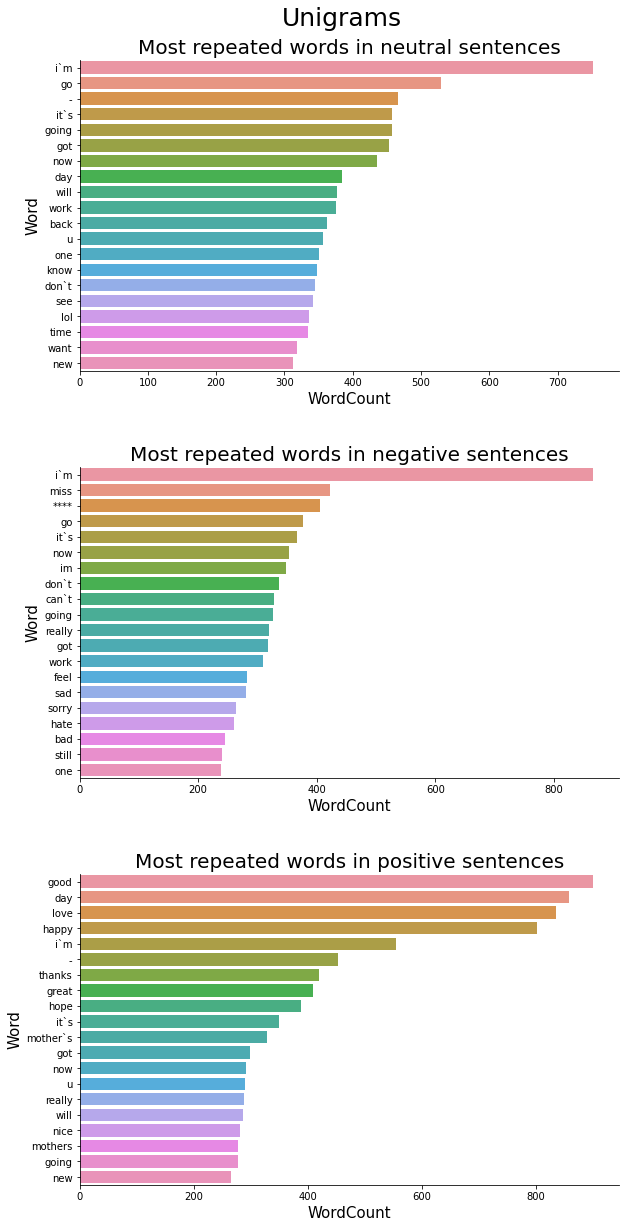

In [22]:
fig, axes = plt.subplots(3, 1, figsize = (10, 18))
plt.tight_layout(pad = 7.5)
plt.suptitle("Unigrams", fontsize = 25)
sns.despine()
l = ["neutral", "negative", "positive"]
for i in range(3):
    sns.barplot(x = "wordcount", y = "word", data = globals()["fd_sorted_" + str(l[i]) + str(1)].iloc[:20, :], ax = axes[i])
    axes[i].set_title(f"Most repeated words in {l[i]} sentences", fontsize = 20)
    axes[i].set_xlabel("WordCount", fontsize = 15)    
    axes[i].set_ylabel("Word", fontsize = 15)

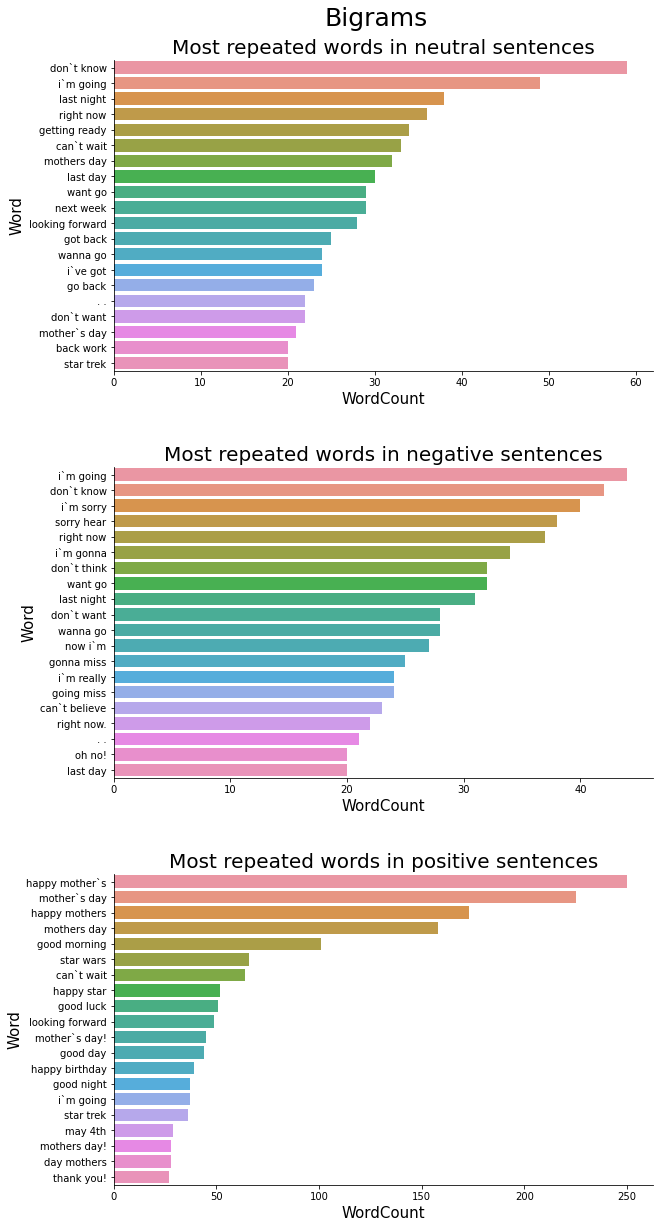

In [23]:
fig, axes = plt.subplots(3, 1, figsize = (10, 18))
plt.tight_layout(pad = 7.5)
plt.suptitle("Bigrams", fontsize = 25)
sns.despine()
l = ["neutral", "negative", "positive"]
for i in range(3):
    sns.barplot(x = "wordcount", y = "word", data = globals()["fd_sorted_" + str(l[i]) + str(2)].iloc[:20, :], ax = axes[i])
    axes[i].set_title(f"Most repeated words in {l[i]} sentences", fontsize = 20)
    axes[i].set_xlabel("WordCount", fontsize = 15)    
    axes[i].set_ylabel("Word", fontsize = 15)

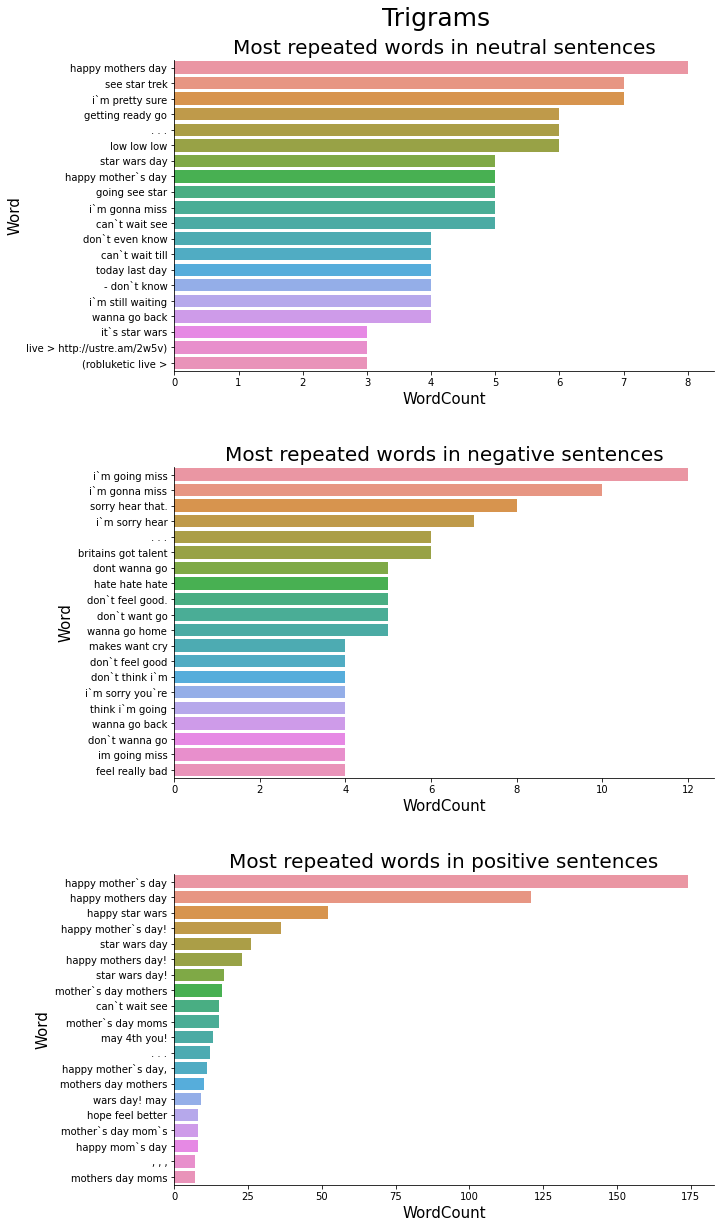

In [24]:
fig, axes = plt.subplots(3, 1, figsize = (10, 18))
plt.tight_layout(pad = 7.5)
plt.suptitle("Trigrams", fontsize = 25)
sns.despine()
l = ["neutral", "negative", "positive"]
for i in range(3):
    sns.barplot(x = "wordcount", y = "word", data = globals()["fd_sorted_" + str(l[i]) + str(3)].iloc[:20, :], ax = axes[i])
    axes[i].set_title(f"Most repeated words in {l[i]} sentences", fontsize = 20)
    axes[i].set_xlabel("WordCount", fontsize = 15)    
    axes[i].set_ylabel("Word", fontsize = 15)

# 7 DistilBERT + SQuAD + Question Answering Technique

In [25]:
train_array = np.array(train.iloc[:, :4])
test_array = np.array(test.iloc[:, :3])
use_cuda = True

# 7.1 Data preparation

In [26]:
# Getting starting index of selected_text found in text
def start_index(text, selected_text):
    start_index = text.lower().find(selected_text.lower())
    l.append(start_index)
    
l = []
for i in range(len(train_array)):
    start_index(train_array[i, 1], train_array[i, 2])

In [27]:
# We are taking
# question --> sentiment
# context --> text
# answer --> selected_text

def quesa_format_train(train):
    out = []
    for i, row in enumerate(train):
        qas = []
        con = []
        ans = []
        question = row[-1]
        answer = row[2]
        context = row[1]
        qid = row[0]
        answer_start = l[i]
        ans.append({"answer_start": answer_start, "text": answer.lower()})
        qas.append({"question": question, "id": qid, "is_impossible": False, "answers": ans})
        out.append({"context": context.lower(), "qas": qas})

    return out
        
    
train_json_format = quesa_format_train(train_array)
with open('data/train.json', 'w') as outfile:
    json.dump(train_json_format, outfile)

In [28]:
# Similarly for text data

def quesa_format_test(train):
    out = []
    for i, row in enumerate(train):
        qas = []
        con = []
        ans = []
        question = row[-1]
#         answer = row[2]
        context = row[1]
        qid = row[0]
        answer_start = l[i]
        ans.append({"answer_start": 1000000, "text": "__None__"})
        qas.append({"question": question, "id": qid, "is_impossible": False, "answers": ans})
        out.append({"context": context.lower(), "qas": qas})
    return out
        
    
test_json_format = quesa_format_test(test_array)

with open('data/test.json', 'w') as outfile:
    json.dump(test_json_format, outfile)

In [29]:
!pip install '/kaggle/input/train-requirements/seqeval-0.0.12-py3-none-any.whl' -q
!pip install '/kaggle/input/train-requirements/simpletransformers-0.22.1-py3-none-any.whl' -q

In [30]:
from simpletransformers.question_answering import QuestionAnsweringModel

model_path = '/kaggle/input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad/'
# MODEL_PATH = QuestionAnsweringModel.from_pretrained('distilbert-base-uncased-distilled-squad'

# Create the QuestionAnsweringModel
model = QuestionAnsweringModel('distilbert', 
                               model_path, 
                               args={'reprocess_input_data': True,
                                     'overwrite_output_dir': True,
                                     'learning_rate': 5e-5,
                                     'num_train_epochs': 4,
                                     'max_seq_length': 128,
                                     'doc_stride': 64,
                                     'fp16': False,
                                    },
                              use_cuda=use_cuda)

model.train_model('data/train.json')

100%|██████████| 27480/27480 [00:52<00:00, 528.01it/s]


Running loss: 3.922992

/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.808490


Running loss: 0.933174


Running loss: 0.362152

In [31]:
pred = model.predict(test_json_format)

100%|██████████| 3534/3534 [00:05<00:00, 636.18it/s]


In [32]:
df = pd.DataFrame.from_dict(pred)
sample_submission["selected_text"] = df["answer"]
# new_df = sample_submission.merge(test,how="inner",on="textID")
# new_df["selected_text"] = np.where((new_df["sentiment"] == "neutral"),new_df["text"], new_df["selected_text"])
# submission = new_df[["textID", "selected_text"]]
sample_submission.to_csv("submission.csv", index = False)
print("File submitted successfully.")

File submitted successfully.


<span style="color:green">**Do upvote this kernel if you found this helpful. Stay tuned!, i will update this kernel regularly**</span>